# HRV EDA

In [1]:
import importlib
import scripts.project_utils.deciles as deciles
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scripts.general_utils import utils
from scripts.general_utils.OverallDetailComparisonPlot import OverallDetailComparisonPlot
import os
import pandas as pd

utils.default_plot_format()
utils.pd_display_settings(3)


## multiple test correction
Since multiple values were processed, it is necessary to account for a false positive discovery rate.

Bonferroni correction:
* Is very conservative.
* Dead easy to code
    * Does not matter since I'm using statsmodels library

Benjamini-Yekutieli (fdr_by):
* More conservative (fewer discoveries) but ensures stronger error control in correlated data.
* remains valid under arbitrary dependence (e.g., correlated test statistics).
* Compared to methods like Bonferroni correction, which control FWER, BY correction is less conservative and preserves more statistical power.
    * This allows researchers to detect more true positives while still controlling for false discoveries.
* The main drawback of the BY correction is that it is more conservative than BH, meaning it reduces the number of discoveries slightly.

Predefine where data is and where the plotly images will be saved

In [2]:
import matplotlib as mpl
import plotly.express as px
palette = px.colors.qualitative.Plotly
palette, _ = px.colors.convert_colors_to_same_type(palette, colortype='tuple')
palette = [mpl.colors.rgb2hex(color) for color in palette]
px.defaults.color_discrete_sequence = palette
sns.set_palette(sns.color_palette(palette))
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.labelweight'] = 'bold'
sns.set_context("notebook", rc={"axes.labelweight": "bold"})
mpl.rcParams['scatter.marker'] = 'o'
mpl.rcParams['lines.markersize'] = 20

In [3]:
data_path = r"results\processed_20min_04_15.pkl"
title_addon = " (10 min segments)"

In [4]:
pickled = pd.read_pickle(data_path)
data = pickled["data"]
indicator_columns = pickled["indicator_columns"]
time_metrics = pickled["time_metrics"]
frequency_metrics = pickled["frequency_metrics"]
non_linear_metrics = pickled["non_linear_metrics"]
data.tail()

,t_start,t_end,SDRR,RMSSD,pNN50 (%),Mean HR (bpm),ULF Power,ULF Peak Frequency,ULF Peak Power,VLF Power,...,UCr (g),UACR (mg÷g),Complications,Nephropathy,Retinopathy and cataract,DPN,Heart Disease,atherosclerosis or stenosis,Carotid Plaque,Condition
1597,20405,21605,41.26,47.90,31.43,76.36,3.41e-09,0.0025,2.41e-06,1.31e-06,...,7.26,2.88,1,1,0,1,0,0,1,DPN
1598,21606,22806,37.65,29.76,8.08,78.62,1.62e-09,0.0025,1.54e-06,2.77e-06,...,7.26,2.88,1,1,0,1,0,0,1,DPN
1599,22806,24006,41.37,20.94,2.06,82.40,2.78e-08,0.0025,3.78e-05,4.39e-06,...,7.26,2.88,1,1,0,1,0,0,1,DPN
1600,80425,81625,11.32,5.31,0,82.25,1.85e-08,0.00167,1.39e-05,2.86e-06,...,8.77,1.52,1,0,0,1,1,0,0,DPN
1601,75689,76888,160.83,211.30,28.49,76.05,1.15e-09,0.0025,1.21e-06,3.9e-07,...,10.23,0.43,1,0,0,1,0,0,1,DPN


In [5]:
", ".join(indicator_columns)

'SDRR, RMSSD, pNN50 (%), Mean HR (bpm), VLF Power, VLF Peak Frequency, LF Power, LF Peak Frequency, HF Power, HF Peak Frequency, LF÷HF Ratio, S, SD1, SD2, SD1÷SD2, ApEn, SampEn, DFA α1, DFA α2, D2'

# Illustration of all data

In [6]:
# Normalize the data for each metric in indicator_columns
normalized_data = data.copy()
for metric in indicator_columns:
    values = normalized_data[metric]
    min_val, max_val = values.min(), values.max()
    if min_val != max_val:  # Avoid division by zero
        normalized_data[metric] = (values - min_val) / (max_val - min_val)
    else:
        normalized_data[metric] = 0  # Assign 0 if all values are the same

display(normalized_data[indicator_columns].describe())
normalized_melted = deciles.produce_median_melt(normalized_data, indicator_columns)
data = data[abs(data.D2)<50]

,SDRR,RMSSD,pNN50 (%),Mean HR (bpm),VLF Power,VLF Peak Frequency,LF Power,LF Peak Frequency,HF Power,HF Peak Frequency,LF÷HF Ratio,S,SD1,SD2,SD1÷SD2,ApEn,SampEn,DFA α1,DFA α2,D2
count,1602,1602,1602,1602,1602,1602,1602,1602,1602,1602,1602,1602,1602,1602,1602,1602,1602,1602,1602,1510
mean,0.28,0.20,0.14,0.42,0.0508,0.77,0.15,0.67,0.33,0.74,0.12,0.11,0.20,0.31,0.38,0.49,0.33,0.45,0.45,0.95
std,0.19,0.18,0.18,0.18,0.0949,0.20,0.14,0.30,0.19,0.22,0.11,0.16,0.18,0.20,0.18,0.20,0.16,0.15,0.17,0.0441
min,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25%,0.13,0.0653,0.0149,0.29,0.00686,0.64,0.0685,0.44,0.18,0.58,0.0603,0.014,0.0653,0.16,0.23,0.33,0.20,0.33,0.33,0.94
50%,0.24,0.15,0.0709,0.41,0.0163,0.81,0.10,0.78,0.29,0.81,0.0858,0.0467,0.15,0.27,0.39,0.49,0.32,0.42,0.45,0.95
75%,0.37,0.28,0.19,0.54,0.0561,0.93,0.17,0.92,0.43,0.93,0.13,0.12,0.28,0.41,0.51,0.64,0.43,0.56,0.56,0.97
max,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


# Median only comparison:
We first derive median of each metric and put them into a single df

In [7]:
median_melted = deciles.produce_median_melt(data, indicator_columns)

median_melted.tail(3)

,id,DPN,metric,value
517,38,1,D2,-5.12
518,39,1,D2,-3.22
519,40,1,D2,-3.07


In [8]:
from scripts.general_utils import CorrectedMultivariableTest as CMT

importlib.reload(CMT)


test = CMT.CorrectedMultivariableTest(
    data=median_melted, 
    group_col='metric',
    value_col='value',
    cat_col='DPN',
    cat_val_1=False,
    cat_val_2=True
)


result = test.perform_ManWhitney_U_tests()
result.sort_values('p_value', inplace=True)
display(result)
result.reset_index(inplace=True, drop=False)

,U_statistic,p_value,significant,rank,BH_threshold,BH_Significant
metric,,,,,,
LF Power,77,0.0162,True,20,0.05,True
HF Power,74,0.0322,True,19,0.0475,True
HF Peak Frequency,17,0.0577,False,18,0.045,False
SD1,70,0.0689,False,17,0.0425,False
S,70,0.0689,False,16,0.04,False
RMSSD,70,0.0689,False,15,0.0375,False
SD2,69,0.0815,False,14,0.035,False
VLF Peak Frequency,68,0.0959,False,13,0.0325,False
SDRR,68,0.0959,False,12,0.03,False


In [9]:
result[result['p_value'] < 0.1].index

Index([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype='int64')

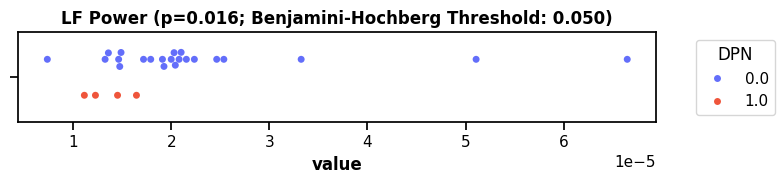

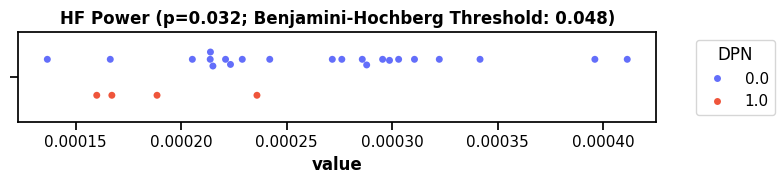

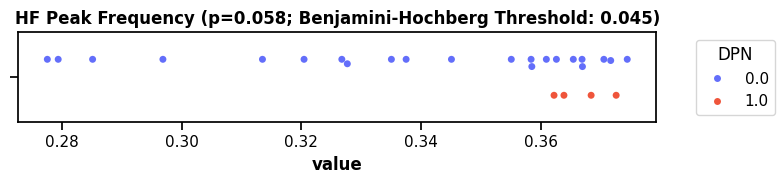

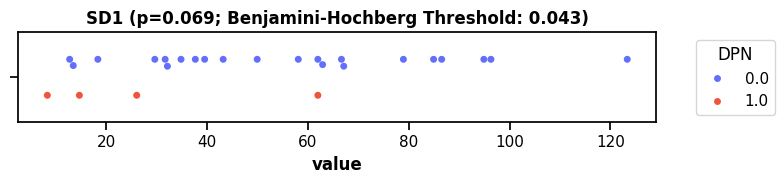

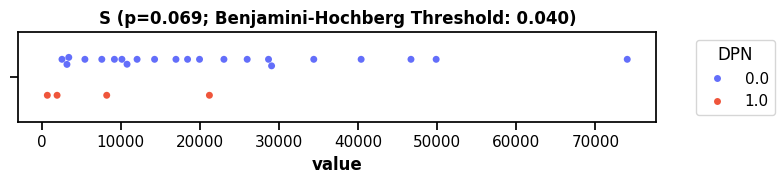

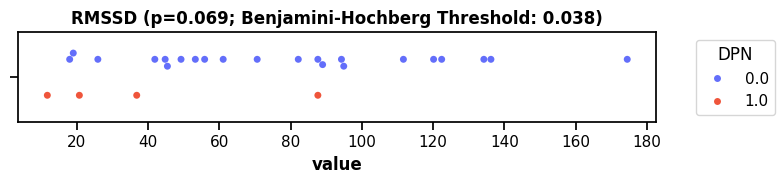

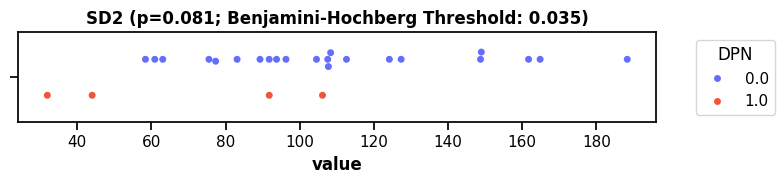

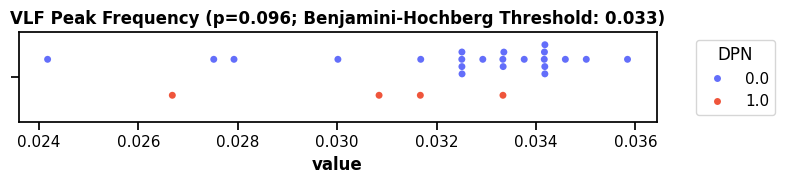

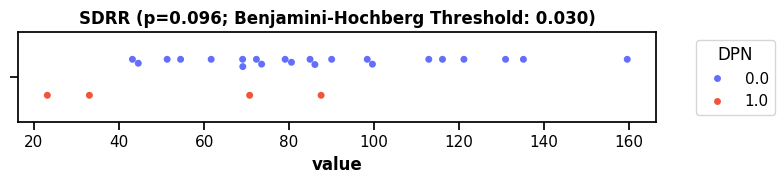

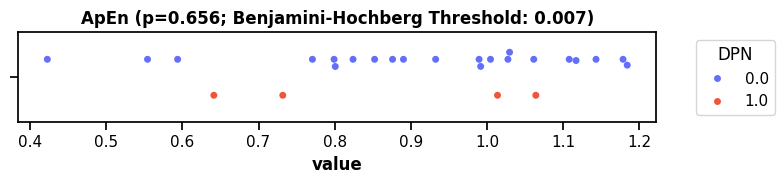

In [10]:
for i, row in result.iterrows():
    if row['p_value'] < 0.1 or (row['metric'] == 'ApEn'):
        title = f"{row['metric']} (p={row['p_value']:.3f}; Benjamini-Hochberg Threshold: {row['BH_threshold']:.3f})"
        plt.figure(figsize=(8, 2))
        plt.title(title)
        sns.swarmplot(
            data=median_melted[median_melted['metric'] == row['metric']],  
            hue = 'DPN',
            x='value',
            dodge=True
        )
        # Move legend outside the plot
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='DPN')
        plt.tight_layout()

# MEDIAN ABSOLUTE DEVIATION

In [11]:
def normalize_melt(df):
    df = df[df.metric!='D2']
    for metric in df["metric"].unique():
        mask = df["metric"]==metric
        values = df[df["metric"]==metric]["value"]
        df.loc[mask, "value"] = values / values.max()

    return df


def plot_normalized(df, title=None, figsize=(8, 15)):
    plt.figure(figsize=figsize)
    sns.swarmplot(data=df, y='metric', x='value', hue = 'DPN', size=4)
    plt.title(title)
    plt.show()

In [12]:
# Mad values
import scipy.stats as stats
import numpy as np


mad=data.groupby(["id", 'DPN'])[indicator_columns].agg(stats.median_abs_deviation)
mad_melt = mad.reset_index().melt(id_vars=["id", 'DPN'], value_vars=indicator_columns, var_name='metric', value_name = 'value')
display(mad_melt)

,id,DPN,metric,value
0,0,0,SDRR,15.33
1,3,0,SDRR,26.10
2,4,0,SDRR,23.99
3,5,0,SDRR,10.09
4,6,0,SDRR,33.32
...,...,...,...,...
515,34,0,D2,0.26
516,37,1,D2,0.70
517,38,1,D2,3.20
518,39,1,D2,0.94


In [13]:
test = CMT.CorrectedMultivariableTest(
    data=mad_melt, 
    group_col='metric',
    value_col='value',
    cat_col='DPN',
    cat_val_1=False,
    cat_val_2=True
)


result = test.perform_ManWhitney_U_tests()
result.sort_values('p_value', inplace=True)
display(result)
result.reset_index(inplace=True, drop=False)

,U_statistic,p_value,significant,rank,BH_threshold,BH_Significant
metric,,,,,,
VLF Peak Frequency,9,0.0095,True,20,0.05,True
ApEn,15,0.0395,True,19,0.0475,True
D2,16,0.048,True,18,0.045,False
SD1÷SD2,16,0.048,True,17,0.0425,False
DFA α1,21,0.11,False,16,0.04,False
LF Peak Frequency,23,0.15,False,15,0.0375,False
S,63,0.20,False,14,0.035,False
LF÷HF Ratio,25,0.20,False,13,0.0325,False
HF Peak Frequency,62,0.22,False,12,0.03,False


In [14]:
result[result.p_value<0.1].index

Index([0, 1, 2, 3], dtype='int64')

In [15]:
#to_plot = [x for x in time_metrics if x != "S"]
#figsize = (8, 5)
#plot_normalized(normalize_melt(mad_melt[mad_melt["metric"].isin(to_plot )]), "Normalized Median Absolute Deviation Distribution", figsize)
#plot_normalized(normalize_melt(median_melted[median_melted["metric"].isin(to_plot )]), "Normalized Median Distribution", figsize)

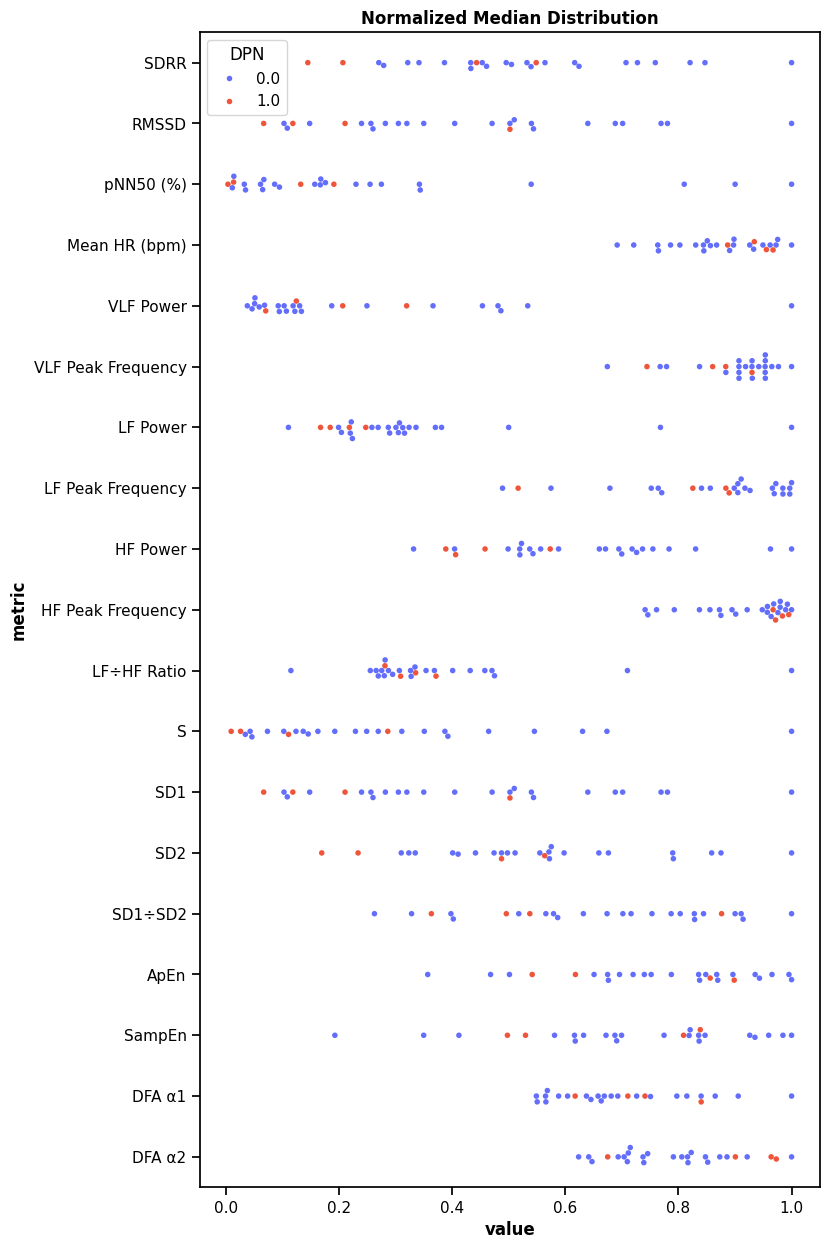

In [16]:
plot_normalized(normalize_melt(median_melted), "Normalized Median Distribution")


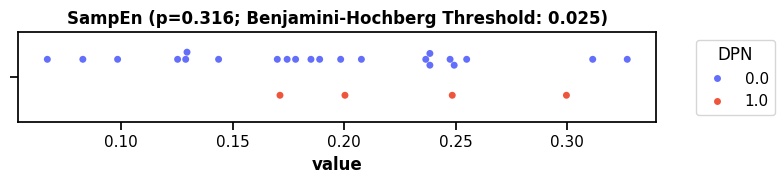

In [17]:
for i, row in result.iterrows():
    if  row["metric"]=="SampEn":
        title = f"{row['metric']} (p={row['p_value']:.3f}; Benjamini-Hochberg Threshold: {row['BH_threshold']:.3f})"
        plt.figure(figsize=(8, 2))
        plt.title(title)
        sns.swarmplot(
            data=mad_melt[mad_melt['metric'] == row['metric']],  
            hue = 'DPN',
            x='value',
            dodge=True
        )
        # Move legend outside the plot
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='DPN')
        plt.tight_layout()

# Permutations test

In [18]:
stats.permutation_test

<function scipy.stats._resampling.permutation_test(data, statistic, *, permutation_type='independent', vectorized=None, n_resamples=9999, batch=None, alternative='two-sided', axis=0, random_state=None)>

## Permutation test

In [19]:
importlib.reload(CMT)
import numpy as np
from copy import deepcopy

test = CMT.CorrectedMultivariableTest(
    data=median_melted, 
    group_col='metric',
    value_col='value',
    cat_col='DPN',
    cat_val_1=True,
    cat_val_2=False
)

def statistic(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

result = test.permutation_test(statistic, n_permutations=200000)

result.sort_values('p_value', inplace=True)
to_print = deepcopy(result)
to_print.drop(columns=["distribution"], inplace=True)
display(to_print)


,perm_statistic,p_value,significant,rank,BH_threshold,BH_Significant
metric,,,,,,
HF Power,-7.88e-05,0.0238,True,20,0.05,True
LF Power,-9.09e-06,0.0355,True,19,0.0475,True
SD2,-40.35,0.0371,True,18,0.045,True
SDRR,-34.27,0.0416,True,17,0.0425,True
HF Peak Frequency,0.0279,0.0499,True,16,0.04,False
SD1,-27.94,0.0738,False,15,0.0375,False
RMSSD,-39.51,0.0738,False,14,0.035,False
DFA α2,0.11,0.0918,False,13,0.0325,False
S,-14080.20,0.0919,False,12,0.03,False


,perm_statistic,p_value,significant,rank,BH_threshold,BH_Significant
metric,,,,,,
HF Power,-7.88e-05,0.0238,True,20,0.05,True


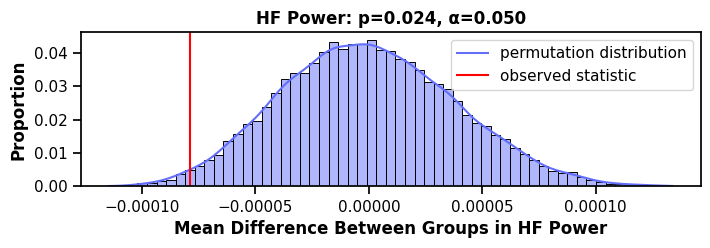

,perm_statistic,p_value,significant,rank,BH_threshold,BH_Significant
metric,,,,,,
LF Power,-9.09e-06,0.0355,True,19,0.0475,True


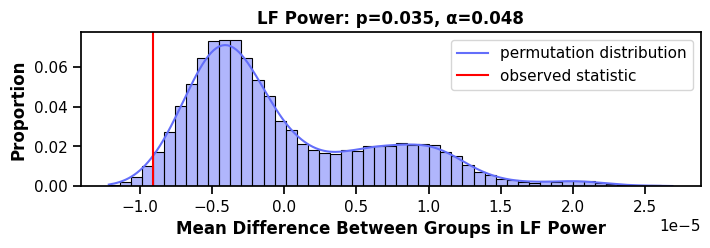

,perm_statistic,p_value,significant,rank,BH_threshold,BH_Significant
metric,,,,,,
SD2,-40.35,0.0371,True,18,0.045,True


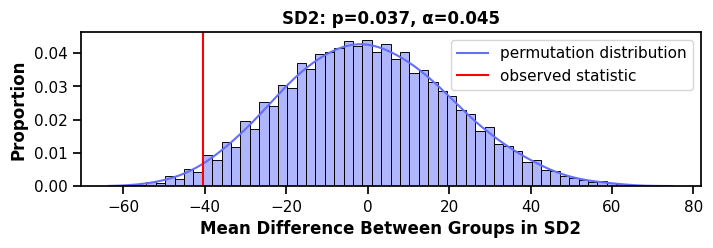

,perm_statistic,p_value,significant,rank,BH_threshold,BH_Significant
metric,,,,,,
SDRR,-34.27,0.0416,True,17,0.0425,True


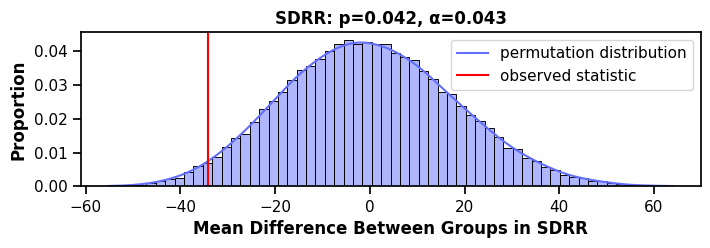

,perm_statistic,p_value,significant,rank,BH_threshold,BH_Significant
metric,,,,,,
HF Peak Frequency,0.0279,0.0499,True,16,0.04,False


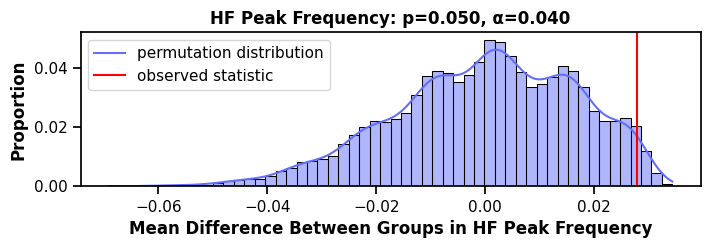

,perm_statistic,p_value,significant,rank,BH_threshold,BH_Significant
metric,,,,,,
SD1,-27.94,0.0738,False,15,0.0375,False


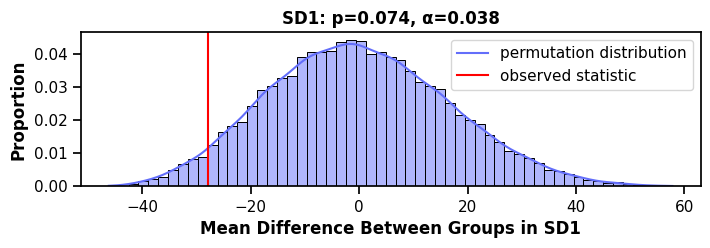

,perm_statistic,p_value,significant,rank,BH_threshold,BH_Significant
metric,,,,,,
RMSSD,-39.51,0.0738,False,14,0.035,False


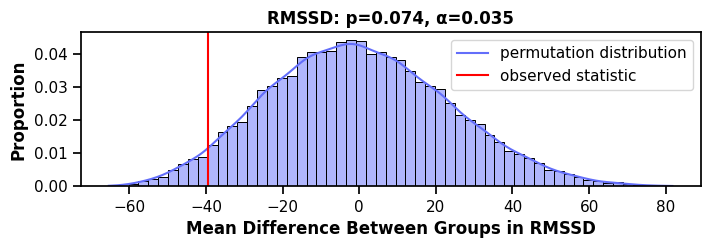

,perm_statistic,p_value,significant,rank,BH_threshold,BH_Significant
metric,,,,,,
DFA α2,0.11,0.0918,False,13,0.0325,False


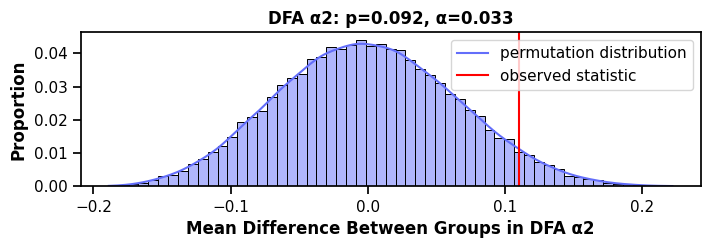

,perm_statistic,p_value,significant,rank,BH_threshold,BH_Significant
metric,,,,,,
S,-14080.20,0.0919,False,12,0.03,False


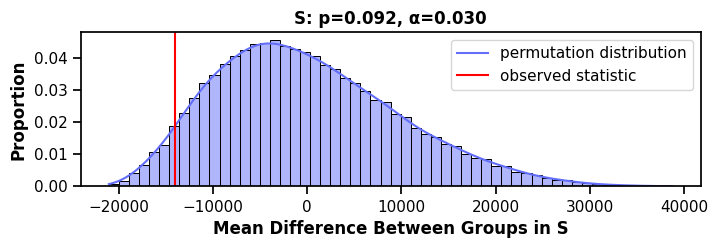

,perm_statistic,p_value,significant,rank,BH_threshold,BH_Significant
metric,,,,,,
Mean HR (bpm),6.15,0.11,False,11,0.0275,False


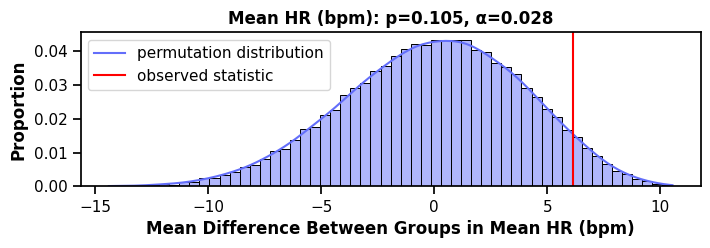

,perm_statistic,p_value,significant,rank,BH_threshold,BH_Significant
metric,,,,,,
pNN50 (%),-7.51,0.17,False,10,0.025,False


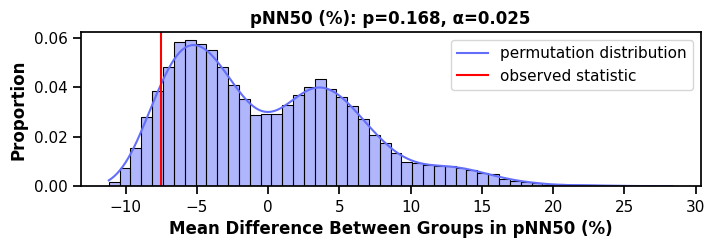

,perm_statistic,p_value,significant,rank,BH_threshold,BH_Significant
metric,,,,,,
D2,-0.60,0.23,False,9,0.0225,False


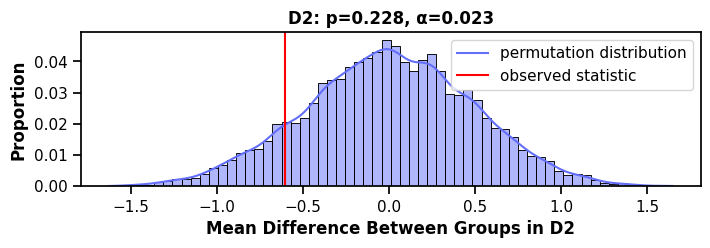

,perm_statistic,p_value,significant,rank,BH_threshold,BH_Significant
metric,,,,,,
VLF Peak Frequency,-0.00184,0.24,False,8,0.02,False


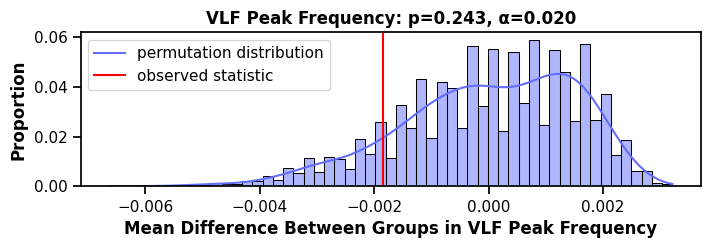

,perm_statistic,p_value,significant,rank,BH_threshold,BH_Significant
metric,,,,,,
LF Peak Frequency,-0.0119,0.29,False,7,0.0175,False


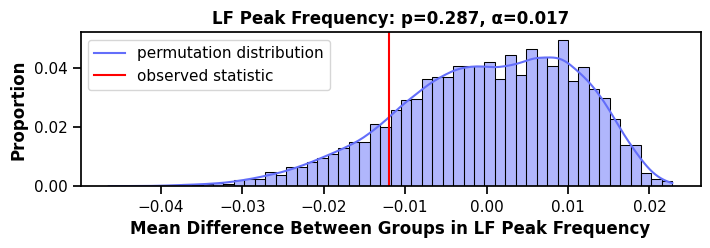

,perm_statistic,p_value,significant,rank,BH_threshold,BH_Significant
metric,,,,,,
SD1÷SD2,-0.0808,0.34,False,6,0.015,False


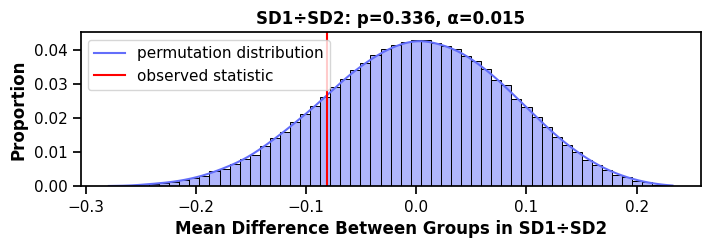

,perm_statistic,p_value,significant,rank,BH_threshold,BH_Significant
metric,,,,,,
SampEn,-0.0613,0.61,False,5,0.0125,False


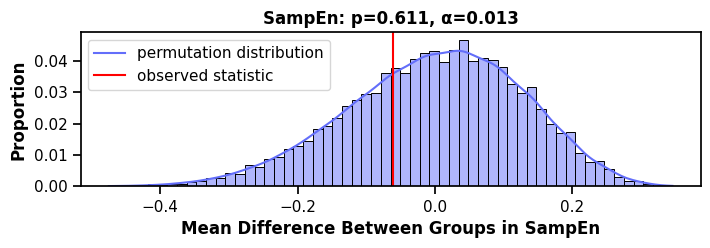

,perm_statistic,p_value,significant,rank,BH_threshold,BH_Significant
metric,,,,,,
ApEn,-0.0532,0.62,False,4,0.01,False


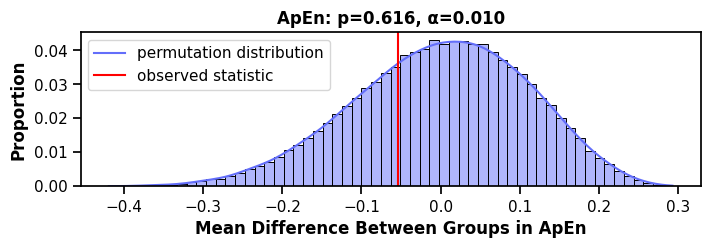

,perm_statistic,p_value,significant,rank,BH_threshold,BH_Significant
metric,,,,,,
DFA α1,0.0388,0.63,False,3,0.0075,False


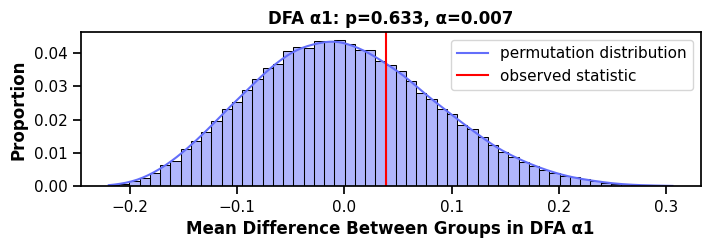

,perm_statistic,p_value,significant,rank,BH_threshold,BH_Significant
metric,,,,,,
LF÷HF Ratio,-0.0127,0.64,False,2,0.005,False


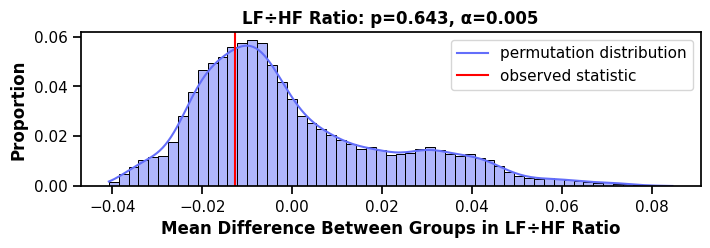

,perm_statistic,p_value,significant,rank,BH_threshold,BH_Significant
metric,,,,,,
VLF Power,-4.41e-07,0.79,False,1,0.0025,False


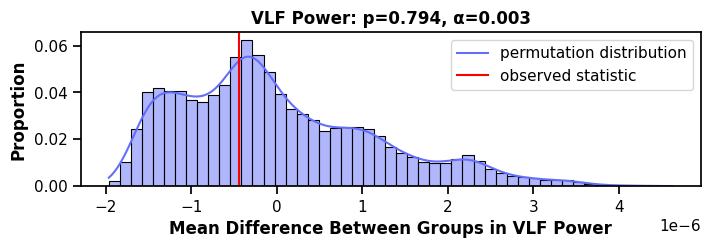

In [20]:
result.tail(3)
for metric in result.index:
    display(to_print[to_print.index == metric])
    plt.figure(figsize=(8, 2))
    sns.histplot(data=result.loc[metric, "distribution"], stat="proportion", kde=True)
    #title = f"permutation test dist. of {metric} 
    plt.title(f"{metric}: p={result.loc[metric, 'p_value']:.3f}, α={result.loc[metric, 'BH_threshold']:.3f}")
    plt.axvline(result.loc[metric, "perm_statistic"], color='red')
    plt.legend(["permutation distribution", "observed statistic"])
    plt.xlabel(f"Mean Difference Between Groups in {metric}")
    plt.show()

In [21]:
#plot_normalized(normalize_melt(median_melted), "Normalized Median Distribution")

## Odds ratio

In [22]:
median = data.groupby(['id', 'DPN'])[indicator_columns].median()
median = median.reset_index()
median.tail(2)

,id,DPN,SDRR,RMSSD,pNN50 (%),Mean HR (bpm),VLF Power,VLF Peak Frequency,LF Power,LF Peak Frequency,...,LF÷HF Ratio,S,SD1,SD2,SD1÷SD2,ApEn,SampEn,DFA α1,DFA α2,D2
24,39,1,33.02,20.69,0.58,83.82,1.99e-06,0.0317,1.11e-05,0.0704,...,0.0749,1941,14.63,44.03,0.36,0.64,0.57,0.95,1.06,-3.22
25,40,1,70.72,36.78,7.98,80.95,1.2e-06,0.0308,1.45e-05,0.12,...,0.0682,8217,26.01,91.78,0.39,1.01,0.96,0.91,0.99,-3.07


In [23]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### KDE derrival
Weight the KDE by number of units

In [24]:
def compute_kde_for_metric(data, metric, weight_data = False):
    # Separate the data based on the 'DPN' column
    control_data = data[data['DPN'] == False][metric]
    dpn_data = data[data['DPN'] == True][metric]

    # Compute the kernel density estimate for each group
    control_kde = stats.gaussian_kde(control_data) 
    dpn_kde = stats.gaussian_kde(dpn_data)  

    x_values = np.linspace(min(data[metric]), max(data[metric]), 100)

    kde_df = pd.DataFrame({
        'x_values': x_values,
        'control_kde': control_kde(x_values),
        'dpn_kde': dpn_kde(x_values),
    })
    if weight_data:
        kde_df["control_kde"] = kde_df["control_kde"] * sum(data['DPN'] == False)/len(data['DPN'])
        kde_df["dpn_kde"] = kde_df["dpn_kde"] * sum(data['DPN'] == True)/len(data['DPN'])

    kde_df["dpn_chance"] = kde_df["dpn_kde"] / (kde_df["dpn_kde"] + kde_df["control_kde"])

    return kde_df

# Example usage
metric = 'SDRR'
kde_df = compute_kde_for_metric(median, metric)
display(kde_df)

,x_values,control_kde,dpn_kde,dpn_chance
0,23.14,0.00162,0.00886,0.84
1,24.51,0.00184,0.00902,0.83
2,25.89,0.00206,0.00918,0.82
3,27.27,0.00231,0.00931,0.80
4,28.65,0.00257,0.00942,0.79
...,...,...,...,...
95,154.01,0.00232,7.6e-05,0.0317
96,155.39,0.0022,6.37e-05,0.0282
97,156.76,0.00208,5.32e-05,0.025
98,158.14,0.00196,4.43e-05,0.0221


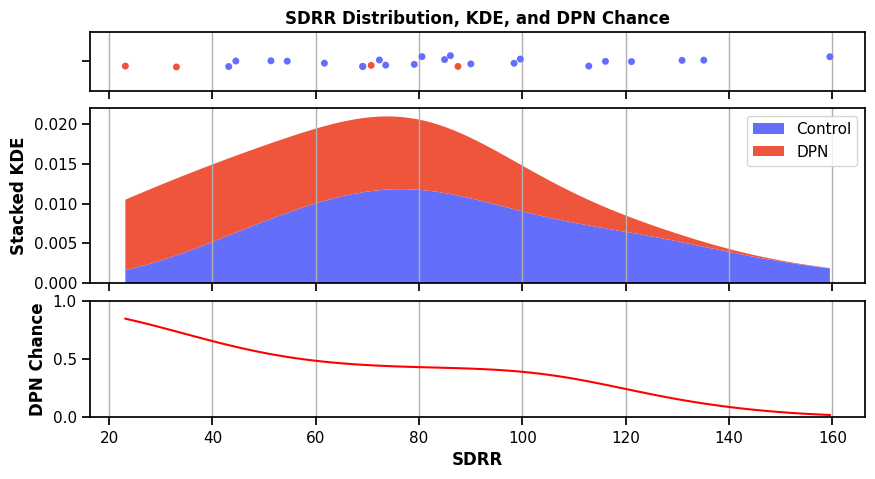

In [25]:
def plot_metric_distribution(metric, kde_df):
   # kde_df = compute_kde_for_metric(median, metric)
    fig, axs = plt.subplots(3, 1, figsize=(10, 5), gridspec_kw={'height_ratios': [1, 3, 2], 'hspace': 0.15})
    
    # Upper subplot
    sns.stripplot(data=median, x=metric, hue='DPN', alpha=1, ax=axs[0])
    axs[0].set_title(f'{metric} Distribution, KDE, and DPN Chance')
    axs[0].grid(True, axis='x')
    axs[0].legend().set_visible(False)

    # Middle subplot
    axs[1].stackplot(kde_df['x_values'], kde_df['control_kde'], kde_df['dpn_kde'], labels=['Control', 'DPN'])
    axs[1].legend()
    axs[1].set_ylabel('Stacked KDE')

    # Lower subplot
    sns.lineplot(data=kde_df, x='x_values', y='dpn_chance', color='red', ax=axs[2])
    axs[2].set_xlabel(metric)
    axs[2].set_ylabel('DPN Chance')
    axs[2].set_ylim(0, 1)

    # Remove x labels for the upper and middle plots
    for ax in axs[:2]:
        ax.set_xlabel('')
        ax.set_xticklabels([])

    for ax in axs:
        ax.grid(True, axis='x')

    #plt.tight_layout()
    plt.show()

kde_df = compute_kde_for_metric(median, 'SDRR')
plot_metric_distribution('SDRR', kde_df)

### Drawing all KDEs

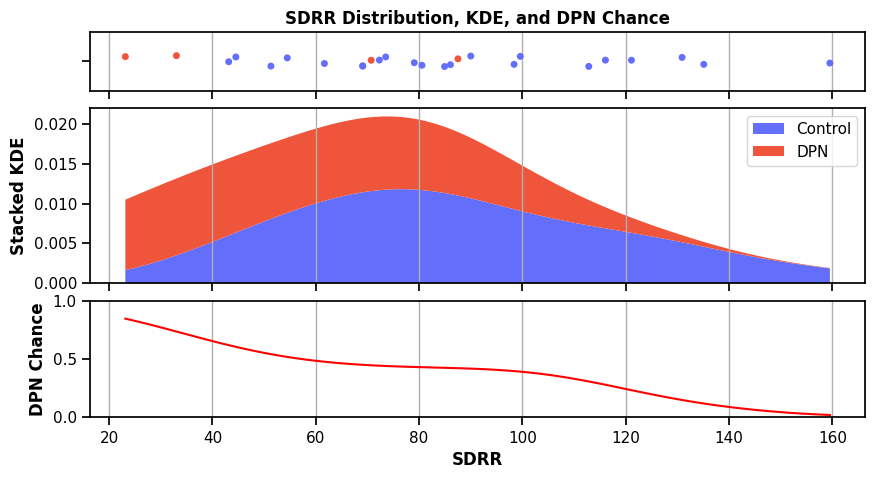

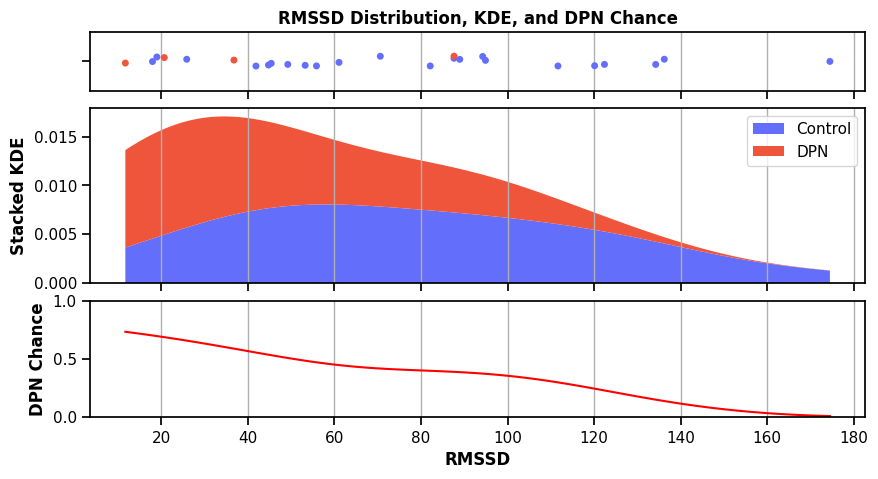

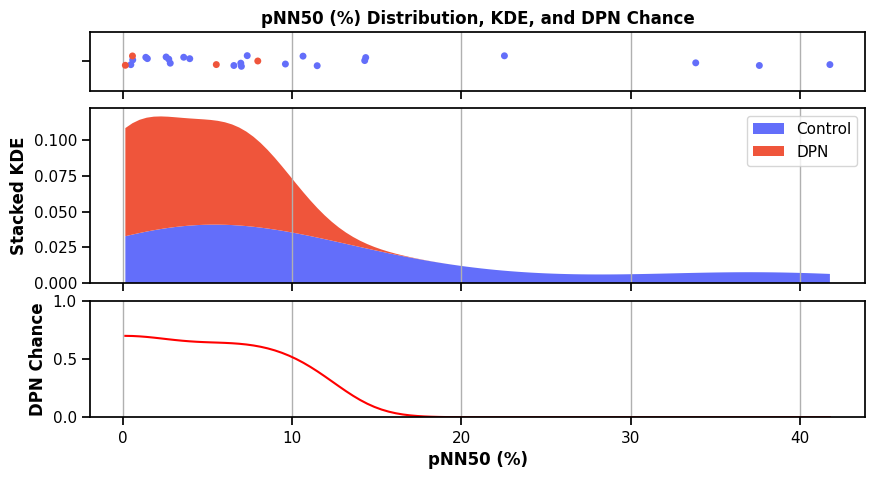

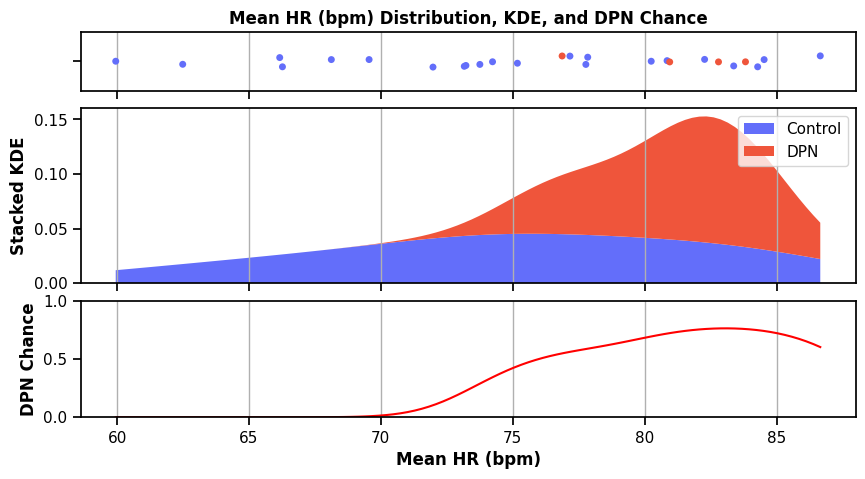

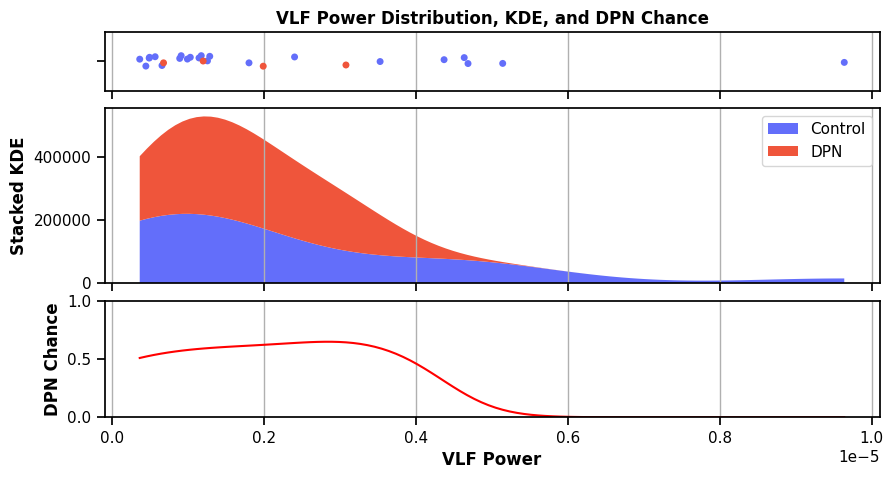

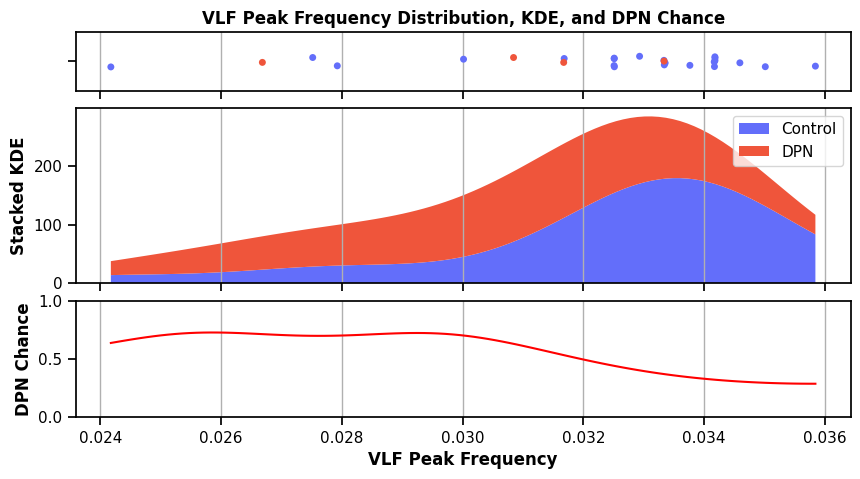

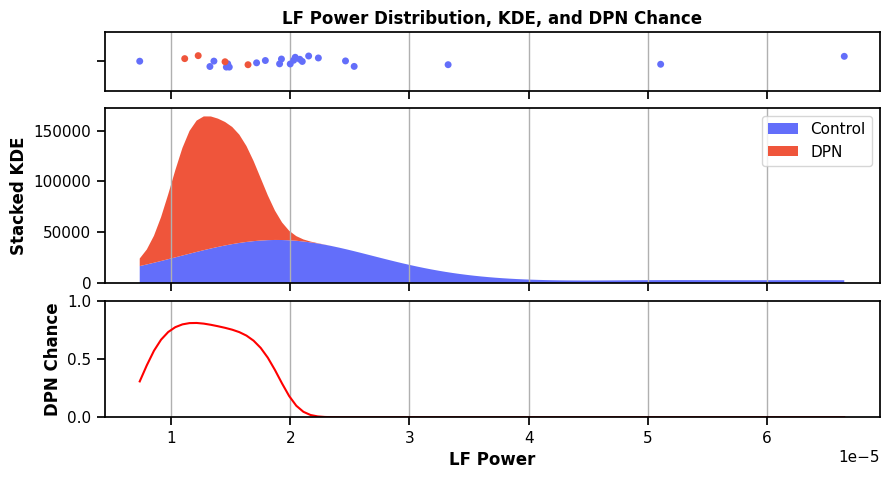

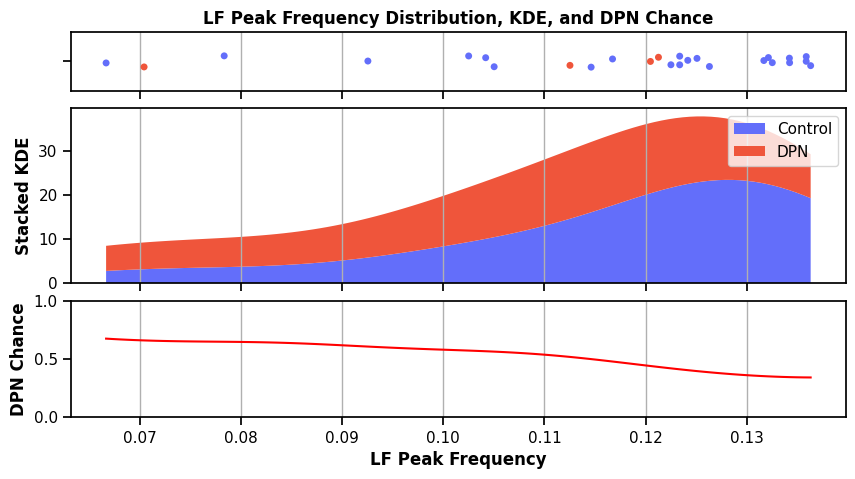

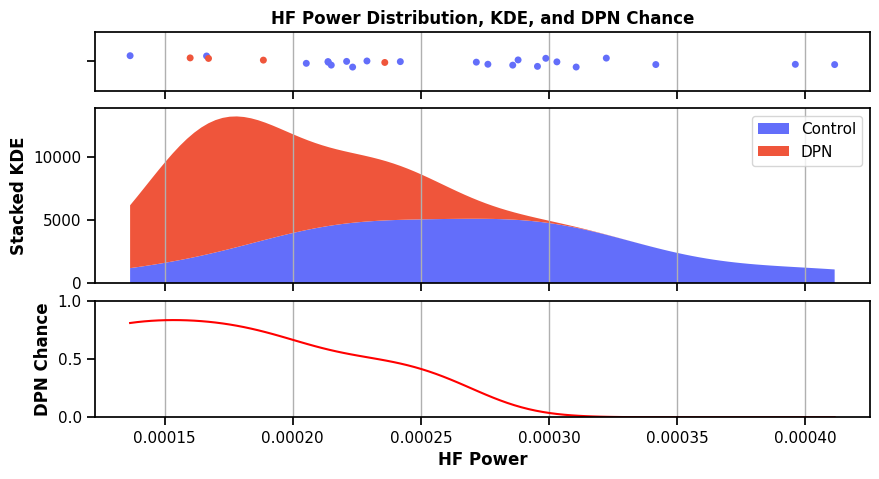

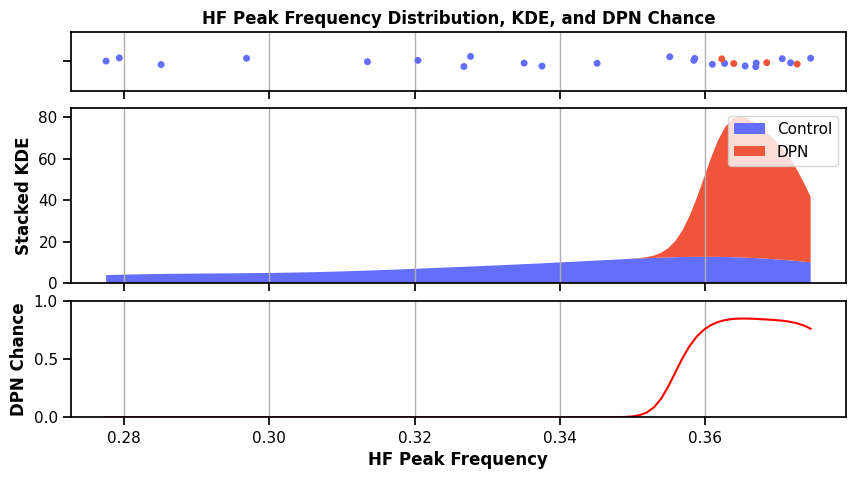

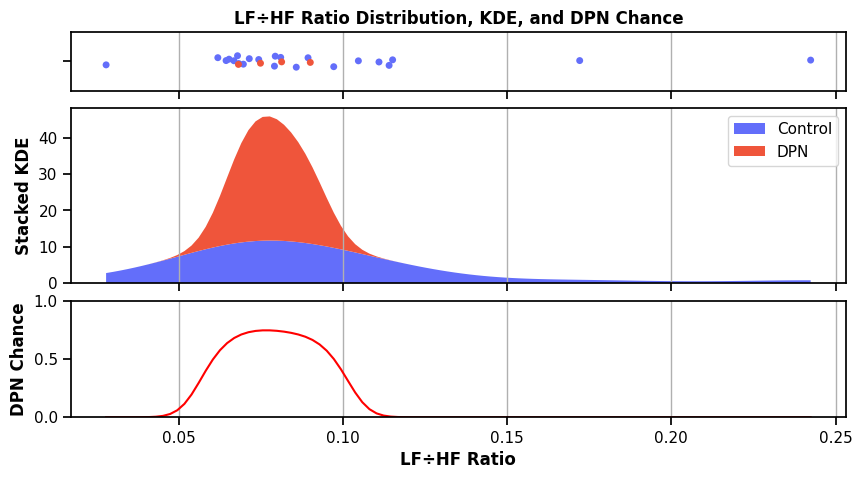

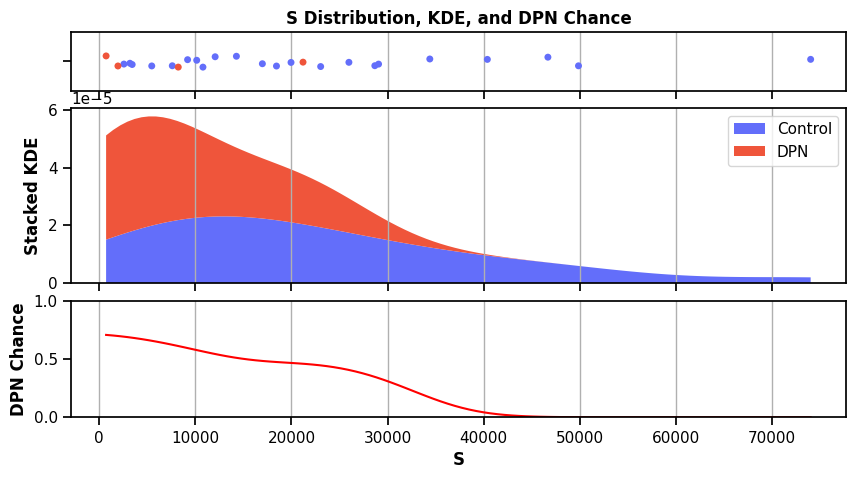

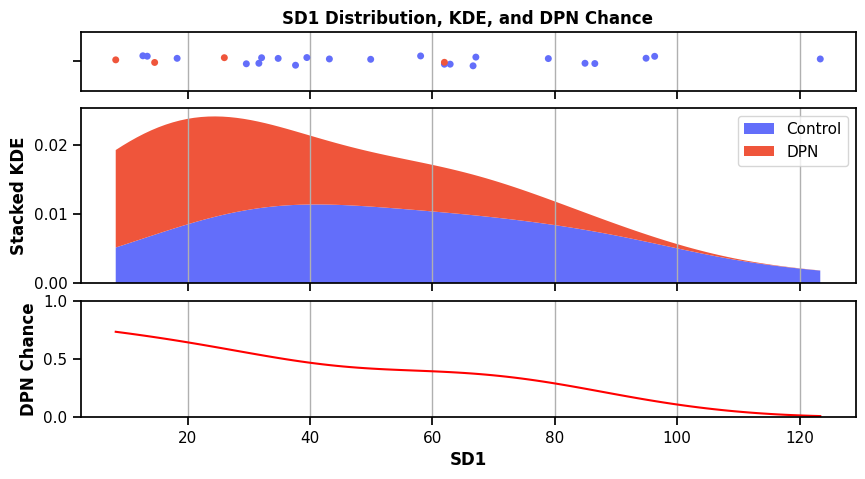

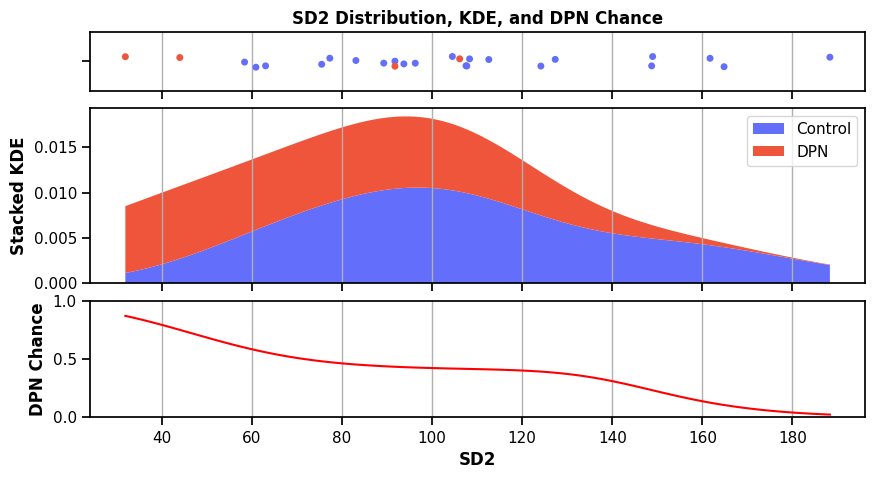

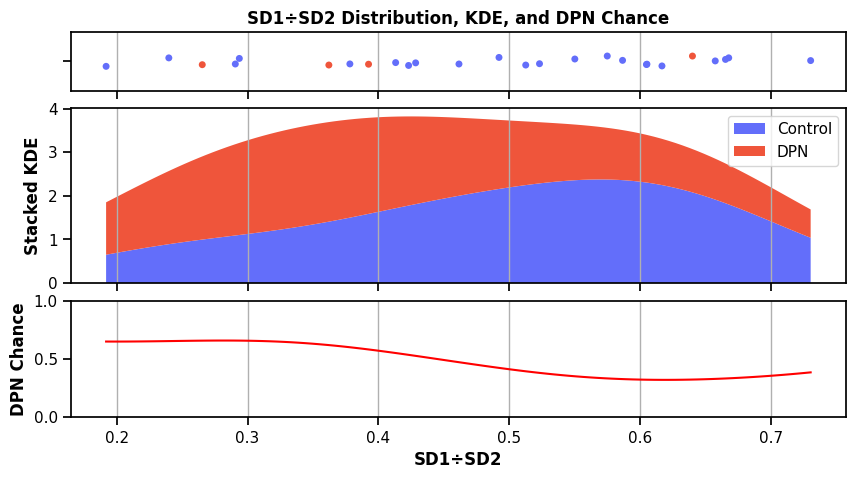

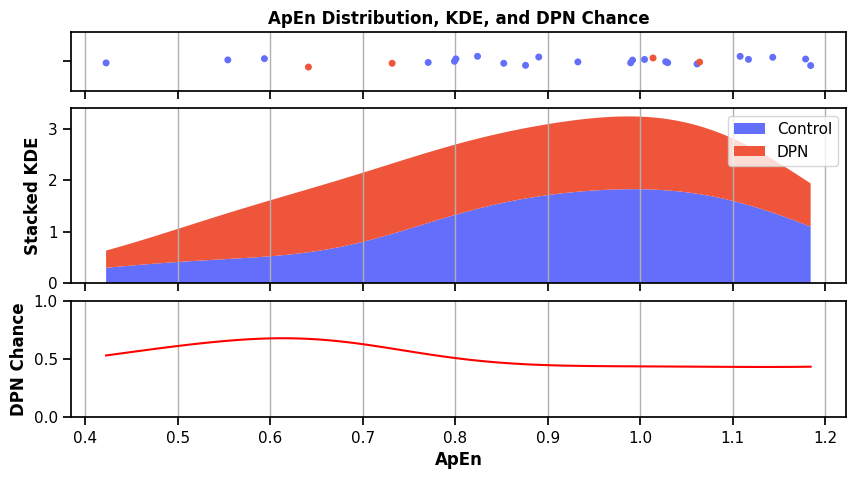

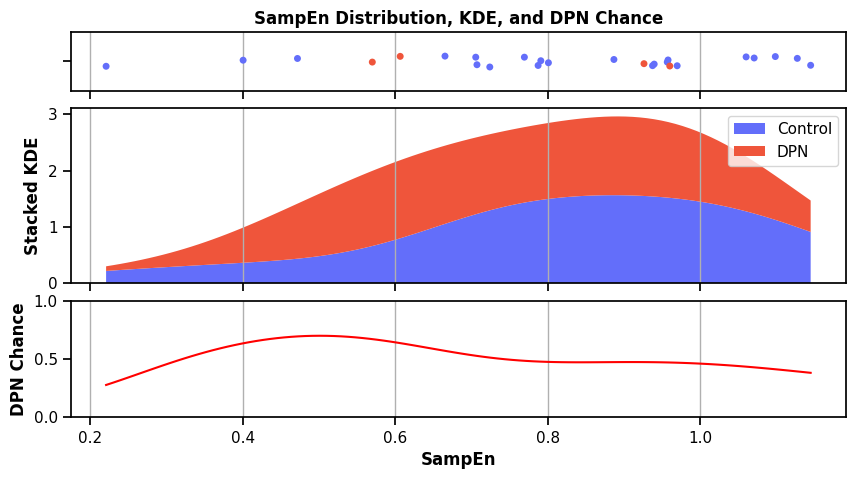

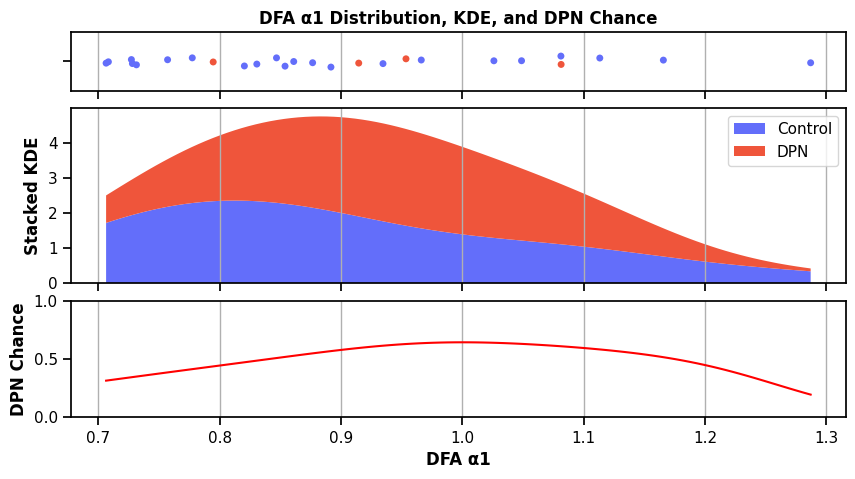

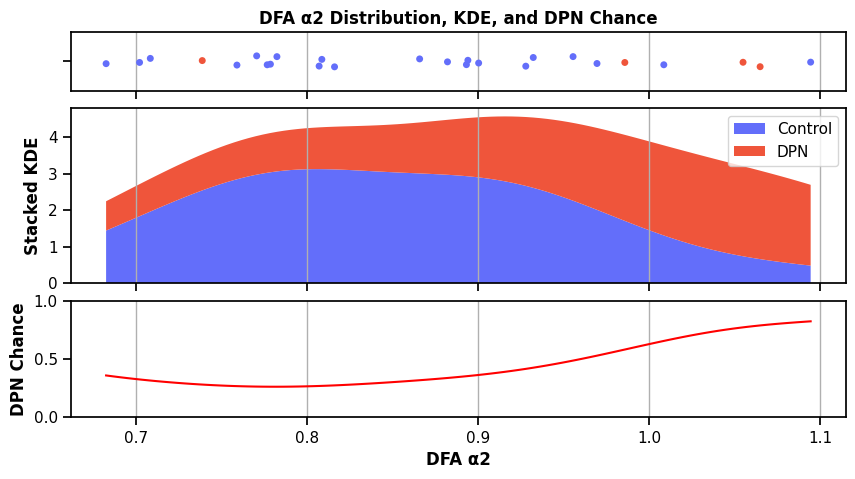

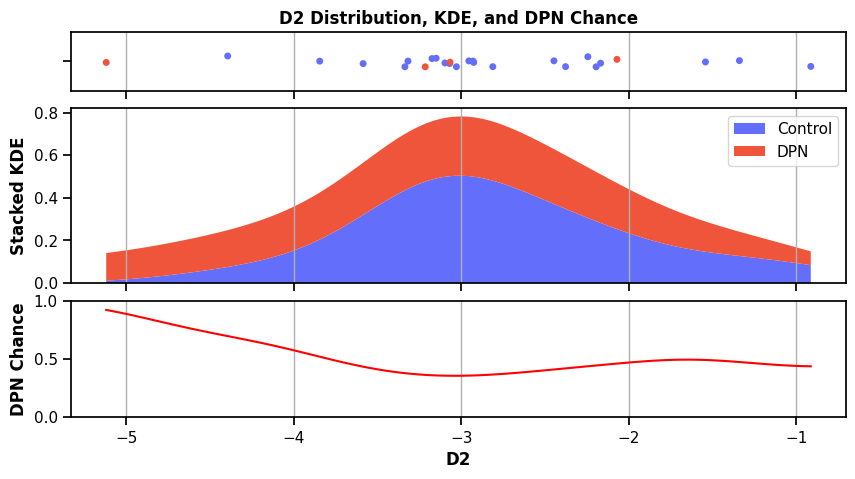

In [26]:
kde_dict = {metric: compute_kde_for_metric(median, metric, False) for metric in indicator_columns}

for metric, kde_df in kde_dict.items():
    plot_metric_distribution(metric, kde_df)